# Intro to k-means

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
Each point is closer to its own cluster center than to other cluster centers.

Let's try

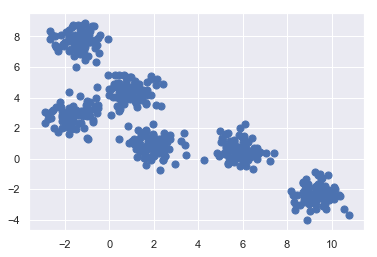

In [8]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=500, centers=6,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

we can easily distinguish that k = 5

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

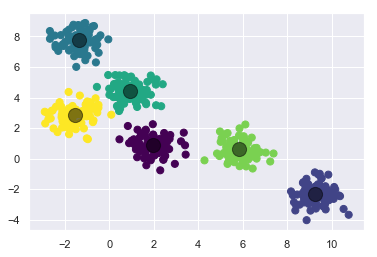

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### k-means: E-M algorithm

(1) 猜测一些簇中心点
（2） 重复直至收敛

a.期望步骤： 将点分配至离其最近的簇中心点--不断更新每个点是属于哪一个簇的期望值
b.最大化步骤：将簇中心点设置为所有点坐标的平均值--计算关于簇中心点拟合函数最大化对应坐标（argmax函数）

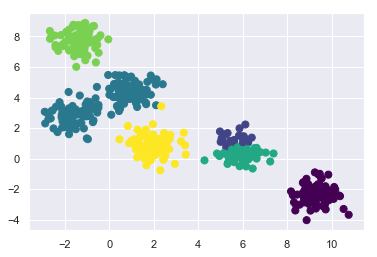

In [19]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 6)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Caveats of expectation–maximization

### The globally optimal result may not be achieved

E-M算法不保证可以获得全局最优的结果，因此该算法通常会用不同的初始值尝试很多遍，通过 n_init 参数设置

### Can't assure the K is the most reasonable one

# K-means for non-linear boundary

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:

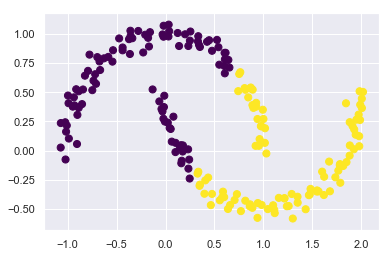

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

we can see from the picture above, this is not the result we want.

Recalling SVM,  we project lower dimension non-linear data to higher dimension, then probably the data will be able to be linear separated

### We can try kernel K-means

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


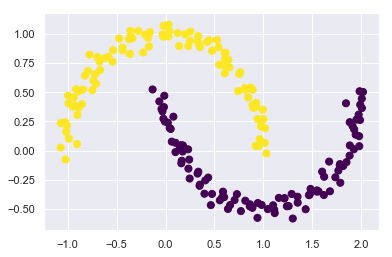

In [9]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

### Effiency

You have to use all the datapoints to get a iteration by k-means, hence we can use a Mini-batch version K-means (sklearn.cluster.MiniBatchKMeans)

# Example 1. digit recognition

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

We got a dataset consisting of 1797 images and each image has 64 features

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

let's visualize them

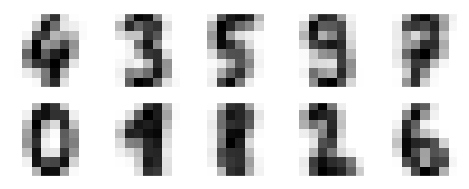

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

we can see from the picture above, it seems can't find out figure 8

a very useful trick : help you compute accuracy when you do clustering

In [24]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] =mode(digits.target[mask])[0]    
    
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.79354479688369506

It seems fine with nearly 80% accuracy 

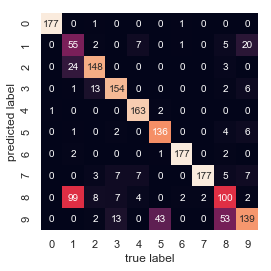

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target,labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Problems mainly  in 1->8 , 5->9, 8->9

### we can try t-sne to pre-process the data

In [27]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.91819699499165275

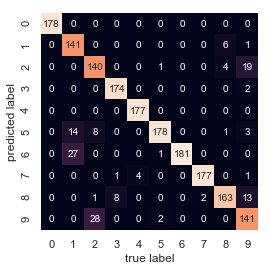

In [28]:
from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(digits.target,labels)
sns.heatmap(mat1.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

That's nearly 92% classification accuracy without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

# Example 2.k-means for color compression

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\base.py:692: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\datasets\base.py:692: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


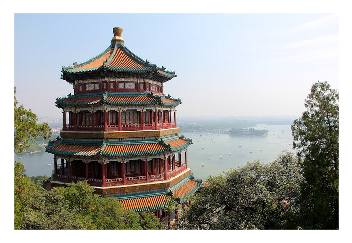

In [20]:

from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [22]:
china.shape
#(height,width,RGB)

(427, 640, 3)

In [24]:
china

array([[[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ..., 
        [250, 251, 255],
        [250, 251, 255],
        [250, 251, 255]],

       [[172, 199, 229],
        [173, 200, 230],
        [173, 200, 230],
        ..., 
        [251, 252, 255],
        [251, 252, 255],
        [251, 252, 255]],

       [[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ..., 
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]],

       ..., 
       [[ 88,  80,   7],
        [147, 138,  69],
        [122, 116,  38],
        ..., 
        [ 39,  42,  33],
        [  8,  14,   2],
        [  6,  12,   0]],

       [[122, 112,  41],
        [129, 120,  53],
        [118, 112,  36],
        ..., 
        [  9,  12,   3],
        [  9,  15,   3],
        [ 16,  24,   9]],

       [[116, 103,  35],
        [104,  93,  31],
        [108, 102,  28],
        ..., 
        [ 43,  49,  39],
        [ 13,  21,   6],
        [ 15,  24,

In [26]:
#feature transformation
data = china/255.
data = data.reshape(427*640,3)
data.shape

(273280, 3)

In [27]:
data

array([[ 0.68235294,  0.78823529,  0.90588235],
       [ 0.68235294,  0.78823529,  0.90588235],
       [ 0.68235294,  0.78823529,  0.90588235],
       ..., 
       [ 0.16862745,  0.19215686,  0.15294118],
       [ 0.05098039,  0.08235294,  0.02352941],
       [ 0.05882353,  0.09411765,  0.02745098]])

In [28]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

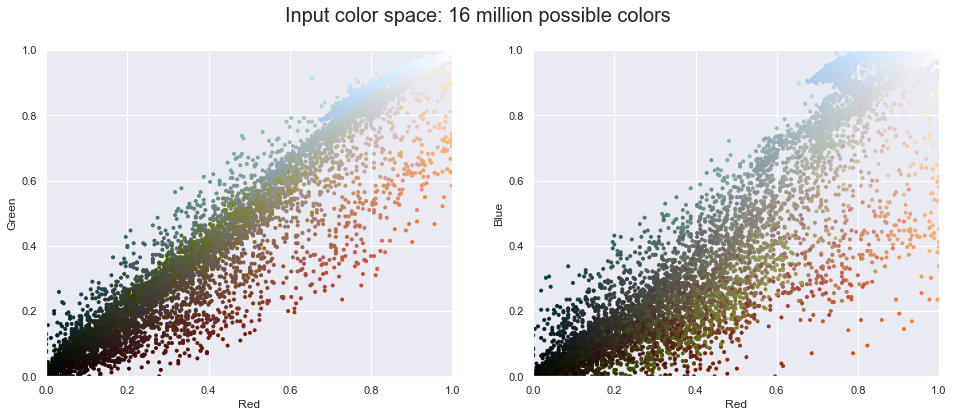

In [29]:
plot_pixels(data,title = 'Input color space: 16 million possible colors')


Now let's reduce these 16 million colors （255 multi 255 multi 255） to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

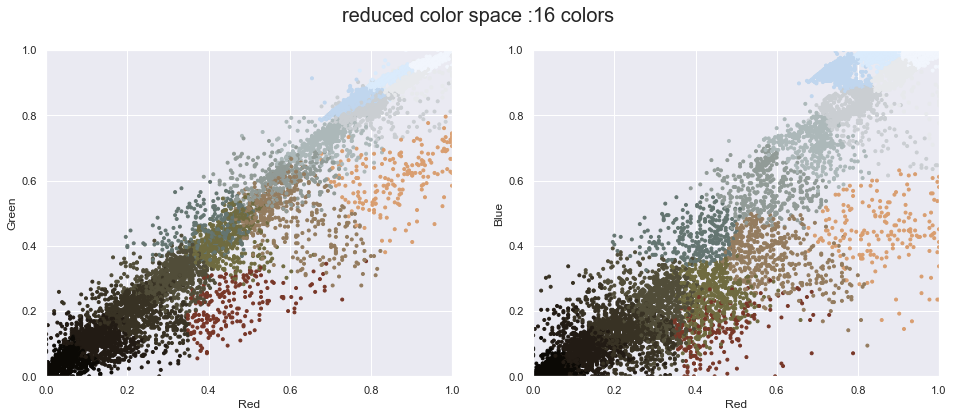

In [32]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors = new_colors,title='reduced color space :16 colors')

redraw the pic with this 16 colors

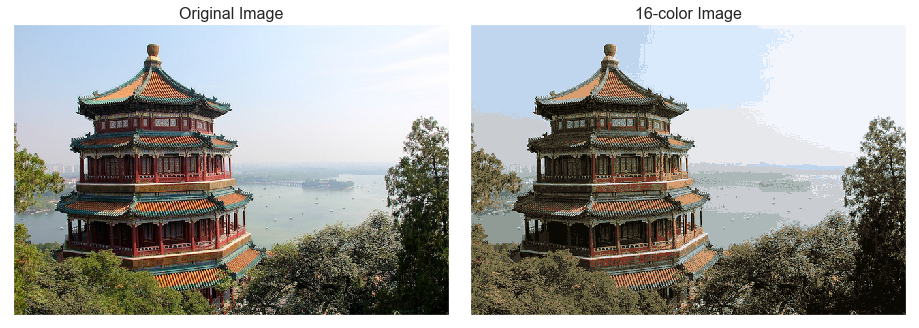

In [33]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);